## Statistics Assignment

All of the following are based on data from your project. Each student has to perform analysis on their own no collaboration between team members. Here are the datasets to be analyzed by team datasets:

***
### ***For Part 1 and 2***

##### Toxic-Crusaders
* Chemical Industry Release (pick a particular industry) by Date-Time


### Part 1

* **Conduct Decriptive Analytics (Mean, Median, Quartile) calculation by each division of Date-Time (most probably year or 6 month duration, if you have shorter use 1 month)**
* **Calculate divergence of mean and median in your data**
* **Visualize the data and draw inferences**

### Part 2
* **Conduct Probablity distibution analysis based on the data. Analyze your data based on the type of distribution it best fits (for PDF and CDF)**
* **Conduct Method of Moments analysis on your data to suggest the best fit distribution. Visualize the results**

***
***

### ***For Part 3***
* Compare with the variable with other variables in your project

### Part 3
* **Formulate a null hypothesis and evaluate it, perform correlation measures, and construct a linear regression model**

***

In [1]:
%matplotlib inline
import pandas, numpy
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

### Read in the Data

There are well over 100 columns, many of which are of little use to consider. 
I am only looking at the following columns:
* YEAR - The year of the report
* TRI_FACILITY_ID - The unique ID assigned to a facility by the EPA/TRI
* FACILITY_NAME / LATITUDE / LONGITUDE - various locational data
* INDUSTRY_SECTOR - The industry or sector (e.g., Coal Mining, Metal Mining, Electrical Utilities, etc.) a facility belongs to. This categorization is primarily used to classify, analyze, and show industrial trends within TRI data.
* CHEMICAL - Chemical released at facility
* UNIT_OF_MEASURE - Units of measurement for the chemical (Grams or Pounds)
* ON-SITE_RELEASE_TOTAL - Total Releases On-site for a chemical at a facility
* OFF-SITE_RELEASE_TOTAL - Total Releases Off-site for a chemical at a facility
* TOTAL_RELEASES - The total on and off-site releases

In [2]:
# theseCols = ['YEAR', 'TRI_FACILITY_ID', 'FACILITY_NAME', 'LATITUDE', 'LONGITUDE', 'INDUSTRY_SECTOR', 'CHEMICAL', 'UNIT_OF_MEASURE', 'ON-SITE_RELEASE_TOTAL', 'OFF-SITE_RELEASE_TOTAL', 'TOTAL_RELEASES']
theseCols = ['YEAR', 'TRI_FACILITY_ID', 'INDUSTRY_SECTOR', 'UNIT_OF_MEASURE', 'ON-SITE_RELEASE_TOTAL', 'OFF-SITE_RELEASE_TOTAL', 'TOTAL_RELEASES']

In [3]:
ncYears = [pandas.read_csv('../data/TRI_'+str(i)+'_NC.csv', usecols=theseCols) for i in range(2000,2017)]

ncIndustryYears = []

for i in range(len(ncYears)):
    ncIndustryYears.append(ncYears[i][(ncYears[i]['INDUSTRY_SECTOR'] != 'Chemicals')].copy())
    # For some reason when reading in the data several duplicate rows are created, so I drop those out
    ncIndustryYears[i].drop_duplicates(inplace=True)

### Convert all Units to Pounds

One problem with the raw data is that not all reports use the same units of measurement, some are in grams, some are in pounds. The below method will convert all reports to pounds, so we can better compare them.

In [4]:
def convertGramsToPounds(df):
    for i in df.index:
        if df.loc[i, ('UNIT_OF_MEASURE')] == 'Grams':
            df.loc[i, ('ON-SITE_RELEASE_TOTAL')] *= 0.00220462
            df.loc[i, ('OFF-SITE_RELEASE_TOTAL')] *= 0.00220462
            df.loc[i, ('TOTAL_RELEASES')] *= 0.00220462
            df.loc[i, ('UNIT_OF_MEASURE')] = 'Pounds'

In [5]:
for i in range(len(ncIndustryYears)):
    convertGramsToPounds(ncIndustryYears[i])

### Group By Location

A single TRI facility may file multiple reports over the course of the year, so it may be useful to consider the total releases PER facility, rather than considering seperate reports from the facility

In [6]:
def consolidateLocations(frame):
    resultFrame = pandas.DataFrame(columns = theseCols)
    
    for i in frame.index:
        if not frame.loc[i, ('TRI_FACILITY_ID')] in resultFrame['TRI_FACILITY_ID'].values:
            resultFrame.loc[len(resultFrame.index)] = frame.loc[i]
        else:
            targInd = resultFrame.index[resultFrame['TRI_FACILITY_ID'] == frame.loc[i, ('TRI_FACILITY_ID')]]
            resultFrame.loc[targInd, ('ON-SITE_RELEASE_TOTAL')] += frame.loc[i, ('ON-SITE_RELEASE_TOTAL')]
            resultFrame.loc[targInd, ('OFF-SITE_RELEASE_TOTAL')] += frame.loc[i, ('OFF-SITE_RELEASE_TOTAL')]
            resultFrame.loc[targInd, ('TOTAL_RELEASES')] += frame.loc[i, ('TOTAL_RELEASES')]
#             resultFrame.loc[targInd, ('CHEMICAL')] += ',' + frame.loc[i, ('CHEMICAL')]
            
    return resultFrame

In [7]:
ncIndustryConsolidated = []

for i in range(len(ncIndustryYears)):
    ncIndustryConsolidated.append(consolidateLocations(ncIndustryYears[i]))
    ncIndustryConsolidated[i].set_index('TRI_FACILITY_ID', inplace=True)
    ncIndustryConsolidated[i].sort_index(inplace=True)
    currYear = ncIndustryConsolidated[i]['YEAR'][0]
    ncIndustryConsolidated[i].rename(index=str, columns={'ON-SITE_RELEASE_TOTAL': 'ON_SITE_RELEASE_TOTAL_'+str(currYear), 'OFF-SITE_RELEASE_TOTAL': 'OFF_SITE_RELEASE_TOTAL_'+str(currYear), 'TOTAL_RELEASES': 'TOTAL_RELEASES_'+str(currYear)}, inplace=True)
    ncIndustryConsolidated[i].drop(['YEAR','INDUSTRY_SECTOR','UNIT_OF_MEASURE'], axis=1, inplace=True)

## Merging the Data

Now lets merge data across multiple years to see trends

In [9]:
industryMerged = pandas.merge(ncIndustryConsolidated[0], ncIndustryConsolidated[1], left_index=True, right_index=True, how='outer')

for i in range(2,len(ncIndustryConsolidated)):
        industryMerged = pandas.merge(industryMerged, ncIndustryConsolidated[i], left_index=True, right_index=True, how='outer')

In [10]:
onSite = ['ON_SITE_RELEASE_TOTAL_'+str(x) for x in range(2000, 2017)]
offSite = ['OFF_SITE_RELEASE_TOTAL_'+str(x) for x in range(2000, 2017)]
totalRelease = ['TOTAL_RELEASES_'+str(x) for x in range(2000, 2017)]

In [11]:
industryMerged.loc[:,onSite].describe()

,ON_SITE_RELEASE_TOTAL_2000,ON_SITE_RELEASE_TOTAL_2001,ON_SITE_RELEASE_TOTAL_2002,ON_SITE_RELEASE_TOTAL_2003,ON_SITE_RELEASE_TOTAL_2004,ON_SITE_RELEASE_TOTAL_2005,ON_SITE_RELEASE_TOTAL_2006,ON_SITE_RELEASE_TOTAL_2007,ON_SITE_RELEASE_TOTAL_2008,ON_SITE_RELEASE_TOTAL_2009,ON_SITE_RELEASE_TOTAL_2010,ON_SITE_RELEASE_TOTAL_2011,ON_SITE_RELEASE_TOTAL_2012,ON_SITE_RELEASE_TOTAL_2013,ON_SITE_RELEASE_TOTAL_2014,ON_SITE_RELEASE_TOTAL_2015,ON_SITE_RELEASE_TOTAL_2016
count,7.430000e+02,7.970000e+02,7.920000e+02,7.650000e+02,7.400000e+02,7.190000e+02,7.150000e+02,6.820000e+02,6.520000e+02,6.240000e+02,6.140000e+02,6.200000e+02,6.310000e+02,6.370000e+02,6.510000e+02,6.650000e+02,6.590000e+02
mean,1.822091e+05,1.619176e+05,1.408800e+05,1.451506e+05,1.490628e+05,1.647254e+05,1.539108e+05,1.465567e+05,1.165765e+05,7.997064e+04,8.145800e+04,7.476895e+04,6.767395e+04,5.978745e+04,6.076604e+04,5.600361e+04,5.468851e+04
std,1.238349e+06,1.158003e+06,9.979333e+05,9.514237e+05,1.017522e+06,1.157548e+06,1.061054e+06,9.414678e+05,6.008713e+05,4.104721e+05,3.962377e+05,3.598637e+05,3.481542e+05,3.173900e+05,3.479694e+05,3.274201e+05,3.032179e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.600000e-03,1.450000e-03
50%,6.710000e+02,2.500000e+02,2.223765e+02,6.490000e+01,6.395000e+01,3.700000e+01,1.887000e+01,2.978500e+01,5.672360e+01,1.772905e+01,2.530028e+01,2.775000e+01,1.703000e+01,1.341000e+01,1.015000e+01,9.810000e+00,7.720000e+00
75%,2.209100e+04,1.564300e+04,1.444775e+04,1.385000e+04,1.187700e+04,1.155441e+04,1.053715e+04,9.437450e+03,7.583750e+03,4.757860e+03,4.488614e+03,6.553000e+03,4.547000e+03,4.200000e+03,3.647000e+03,3.374750e+03,3.410200e+03
max,2.118817e+07,2.104804e+07,1.554356e+07,1.429288e+07,1.420507e+07,1.758758e+07,1.532927e+07,1.374127e+07,6.424079e+06,3.972444e+06,4.373521e+06,3.985817e+06,4.272253e+06,4.671414e+06,4.648701e+06,4.458581e+06,4.467810e+06


In [12]:
industryMerged.loc[:,offSite].describe()

,OFF_SITE_RELEASE_TOTAL_2000,OFF_SITE_RELEASE_TOTAL_2001,OFF_SITE_RELEASE_TOTAL_2002,OFF_SITE_RELEASE_TOTAL_2003,OFF_SITE_RELEASE_TOTAL_2004,OFF_SITE_RELEASE_TOTAL_2005,OFF_SITE_RELEASE_TOTAL_2006,OFF_SITE_RELEASE_TOTAL_2007,OFF_SITE_RELEASE_TOTAL_2008,OFF_SITE_RELEASE_TOTAL_2009,OFF_SITE_RELEASE_TOTAL_2010,OFF_SITE_RELEASE_TOTAL_2011,OFF_SITE_RELEASE_TOTAL_2012,OFF_SITE_RELEASE_TOTAL_2013,OFF_SITE_RELEASE_TOTAL_2014,OFF_SITE_RELEASE_TOTAL_2015,OFF_SITE_RELEASE_TOTAL_2016
count,7.430000e+02,7.970000e+02,7.920000e+02,7.650000e+02,7.400000e+02,7.190000e+02,7.150000e+02,6.820000e+02,6.520000e+02,6.240000e+02,614.000000,6.200000e+02,6.310000e+02,6.370000e+02,6.510000e+02,6.650000e+02,6.590000e+02
mean,1.448886e+04,1.018076e+04,1.053794e+04,9.776379e+03,1.575520e+04,1.397085e+04,1.984139e+04,2.446161e+04,9.287187e+03,8.248936e+03,8144.382371,1.028949e+04,1.296885e+04,1.479403e+04,2.389427e+04,3.256168e+04,1.871861e+04
std,1.196471e+05,9.022262e+04,1.337477e+05,1.150211e+05,2.743044e+05,2.067182e+05,3.729848e+05,4.954795e+05,9.201644e+04,8.238541e+04,52099.879718,9.678758e+04,1.346267e+05,1.614664e+05,2.425997e+05,4.285800e+05,2.202607e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.100000e+02,1.045900e+02,1.067500e+02,9.000000e+01,1.660700e+02,1.559800e+02,1.482500e+02,1.622500e+02,1.331250e+02,8.376250e+01,78.175000,7.115500e+01,2.920000e+01,2.562000e+01,5.235000e+01,4.252000e+01,3.311325e+01
max,2.688005e+06,2.274044e+06,3.667276e+06,3.060419e+06,7.400986e+06,5.427397e+06,9.933622e+06,1.291693e+07,2.050520e+06,1.830948e+06,699251.300000,2.132424e+06,2.423261e+06,3.420420e+06,4.830662e+06,9.156826e+06,4.528026e+06


In [13]:
industryMerged.loc[:,totalRelease].describe()

,TOTAL_RELEASES_2000,TOTAL_RELEASES_2001,TOTAL_RELEASES_2002,TOTAL_RELEASES_2003,TOTAL_RELEASES_2004,TOTAL_RELEASES_2005,TOTAL_RELEASES_2006,TOTAL_RELEASES_2007,TOTAL_RELEASES_2008,TOTAL_RELEASES_2009,TOTAL_RELEASES_2010,TOTAL_RELEASES_2011,TOTAL_RELEASES_2012,TOTAL_RELEASES_2013,TOTAL_RELEASES_2014,TOTAL_RELEASES_2015,TOTAL_RELEASES_2016
count,7.430000e+02,7.970000e+02,7.920000e+02,7.650000e+02,7.400000e+02,7.190000e+02,7.150000e+02,6.820000e+02,6.520000e+02,6.240000e+02,6.140000e+02,6.200000e+02,6.310000e+02,6.370000e+02,6.510000e+02,6.650000e+02,6.590000e+02
mean,1.968893e+05,1.721293e+05,1.514444e+05,1.549481e+05,1.648381e+05,1.787135e+05,1.737674e+05,1.710369e+05,1.258759e+05,8.823179e+04,8.961729e+04,8.507805e+04,8.065175e+04,7.459180e+04,8.474828e+04,8.869714e+04,7.351303e+04
std,1.244001e+06,1.162040e+06,1.007285e+06,9.591120e+05,1.053618e+06,1.175972e+06,1.124006e+06,1.062383e+06,6.094837e+05,4.245602e+05,4.060570e+05,3.768027e+05,3.797316e+05,3.602945e+05,4.280315e+05,5.426072e+05,3.808015e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.852983e-04,6.000000e-03,9.192500e-04,1.984158e-04,9.750000e-03,9.241500e-04,0.000000e+00,2.025000e-03,2.627327e-02,0.000000e+00,6.200000e-03,1.037500e-02,8.900000e-03,6.800000e-03,6.032200e-03,9.000000e-03,5.750000e-03
50%,3.555000e+03,1.384150e+03,8.835000e+02,8.380000e+02,6.780000e+02,5.267050e+02,3.432800e+02,4.966200e+02,5.436800e+02,2.567500e+02,2.500000e+02,3.395295e+02,1.930000e+02,1.704000e+02,1.270000e+02,1.220000e+02,6.000000e+01
75%,3.355250e+04,2.509200e+04,2.251433e+04,2.104098e+04,1.887275e+04,2.026750e+04,1.890018e+04,1.812500e+04,1.402737e+04,7.792661e+03,1.052300e+04,1.137417e+04,8.815500e+03,8.664000e+03,9.157285e+03,7.007000e+03,8.350500e+03
max,2.118829e+07,2.104820e+07,1.554363e+07,1.429294e+07,1.420522e+07,1.758758e+07,1.532930e+07,1.374130e+07,6.424079e+06,3.972444e+06,4.373521e+06,3.991774e+06,4.277142e+06,4.680205e+06,4.992783e+06,9.183804e+06,4.765732e+06


## Observations on Descriptions

For each and every year in the observation (2000-2016), we can see that the mean release value massively dwarfs the median release value, indicating that there are a handful of facilities that are accounting for the vast majority of releases in any given year

In [14]:
YEARS = numpy.arange(2000,2017)[:, numpy.newaxis]

totalModel = LinearRegression()
totalModel.fit(YEARS, industryMerged.loc[:,totalRelease].mean())
print('Total Release coefficient: ' + str(totalModel.coef_))

onSiteModel = LinearRegression()
onSiteModel.fit(YEARS, industryMerged.loc[:,onSite].mean())
print('On-Site Release coefficient: ' + str(onSiteModel.coef_))

offSiteModel = LinearRegression()
offSiteModel.fit(YEARS, industryMerged.loc[:,offSite].mean())
print('Off-Site Release coefficient: ' + str(offSiteModel.coef_))

Total Release coefficient: [-7945.46723649]
On-Site Release coefficient: [-8519.55506686]
Off-Site Release coefficient: [ 573.36876567]


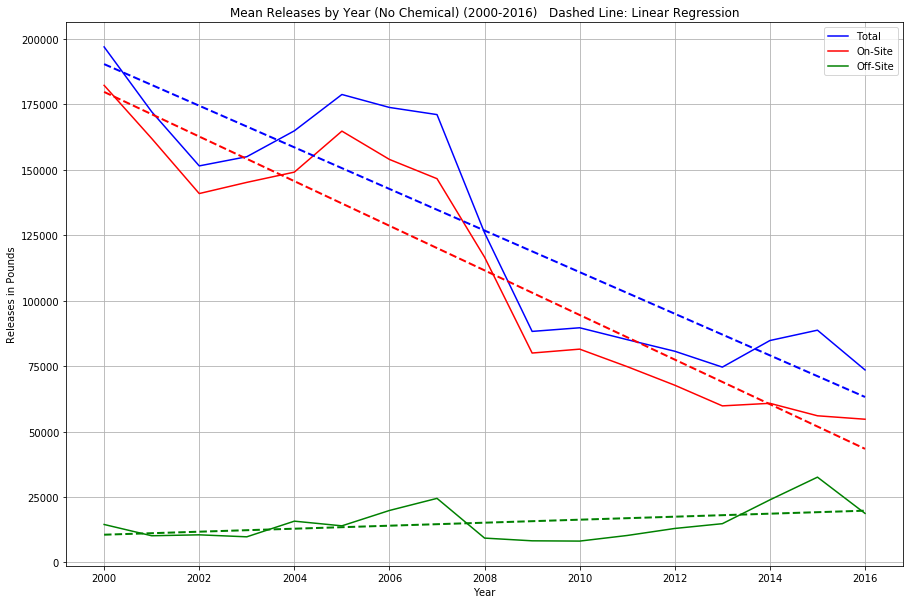

In [17]:
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(range(2000,2017), industryMerged.loc[:,totalRelease].mean(), 'b', label='Total')
ax.plot(range(2000,2017), industryMerged.loc[:,onSite].mean(), 'r', label='On-Site')
ax.plot(range(2000,2017), industryMerged.loc[:,offSite].mean(), 'g', label='Off-Site')

ax.plot(range(2000,2017), totalModel.predict(YEARS), 'b--', linewidth=2)
ax.plot(range(2000,2017), onSiteModel.predict(YEARS), 'r--', linewidth=2)
ax.plot(range(2000,2017), offSiteModel.predict(YEARS), 'g--', linewidth=2)


ax.set_title('Mean Releases by Year (No Chemical) (2000-2016)   Dashed Line: Linear Regression')
ax.set_xlabel('Year')
ax.set_ylabel('Releases in Pounds')
ax.grid()
ax.legend();

### Linear Regression on Mean Releases

Excluding the Chemical Industry from the state totals shows an even more schocking decrease in Toxic Releases. Nearly 8000 pounds less in total releases year over year, an increase of about 3700 pounds per year versus the State taken as a whole

Text(0,0.5,u'Releases')

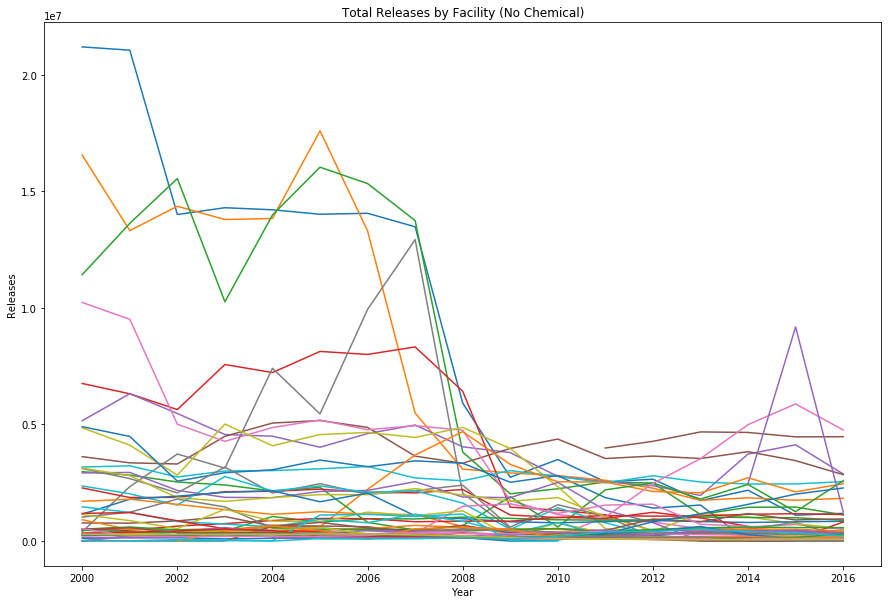

In [18]:
fig, ax = plt.subplots(figsize=(15,10))

for facility in industryMerged[totalRelease].sum(axis=1).sort_values(ascending=False).head(50).index:
    ax.plot(range(2000,2017), industryMerged.loc[facility,totalRelease]);
    
ax.set_title('Total Releases by Facility (No Chemical)')
ax.set_xlabel('Year')
ax.set_ylabel('Releases')

### Releases By Facility

Trying to make a model of the releases by facility seem a difficult task, as facilities that 16 years ago were releasing huge amounts of Toxic Material are now releasing almost nothing, and facilities that were releasing very little now have huge releases. 2009 is an interesting year, where across the board all facilities released significantly less than the years immeadiately before and after. This was during the height of the housing crisis, when the economy was suffering across the board so it seems likely that some of the larger facilities may have had to scale back production, or maybe even shut down, until the economy began to recover. In fact we can see that the largest releasing facilities before and after 2009 are almost completely different, showing there was a shift in the economy of the state.